In [1]:
# =========================================================
# Cell 1 : imports & device
# =========================================================
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt, numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on", DEVICE)
torch.manual_seed(0)

Running on cpu


In [2]:
# =========================================================
# Cell 2 : MNIST subset  (transform to [0,1] tensor)
# =========================================================
mnist_train = datasets.MNIST("./data", train=True , download=True,
                             transform=transforms.ToTensor())
mnist_test  = datasets.MNIST("./data", train=False, download=True,
                             transform=transforms.ToTensor())

train_ds, _  = random_split(mnist_train, [10_000, len(mnist_train)-10_000])
test_ds , _  = random_split(mnist_test , [2_000 , len(mnist_test )-2_000])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds , batch_size=512, shuffle=False)

In [3]:
# =========================================================
# Cell 3 : Bayes-by-Backprop dense layer
#         Each weight & bias gets (μ, ρ) → σ = softplus(ρ)
# =========================================================
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # weight params
        self.mu_w   = nn.Parameter(torch.empty(out_features, in_features).normal_(0, 0.05))
        self.rho_w  = nn.Parameter(torch.full((out_features, in_features), -3.0))
        # bias params
        self.mu_b   = nn.Parameter(torch.zeros(out_features))
        self.rho_b  = nn.Parameter(torch.full((out_features,), -3.0))
        # prior std (fixed)
        self.prior_sigma = 1.0

    def _sample_weight(self, mu, rho):
        sigma = torch.nn.functional.softplus(rho)
        eps   = torch.randn_like(mu)
        return mu + sigma * eps, sigma

    def forward(self, x):
        w, sigma_w = self._sample_weight(self.mu_w, self.rho_w)
        b, sigma_b = self._sample_weight(self.mu_b, self.rho_b)
        self._kl = self.kl_divergence(w, self.mu_w, sigma_w) + \
                   self.kl_divergence(b, self.mu_b, sigma_b)
        return F.linear(x, w, b)

    def kl_divergence(self, sample, mu, sigma):
        # KL between N(mu,sigma^2) and standard normal N(0,1)
        prior_sigma = self.prior_sigma
        return (torch.log(prior_sigma/sigma) +
                (sigma**2 + mu**2) / (2*prior_sigma**2) - 0.5).sum()

In [ ]:
# =========================================================
# Cell 4 : Tiny BNN for 28×28 images → 10 classes
# =========================================================
class BNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = BayesianLinear(28*28, 200)
        self.b2 = BayesianLinear(200, 200)
        self.b3 = BayesianLinear(200,  10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.b1(x))
        x = torch.relu(self.b2(x))
        x = self.b3(x)
        # accumulate KL from each Bayesian layer
        self.kl = self.b1._kl + self.b2._kl + self.b3._kl
        return x

In [5]:
# =========================================================
# Cell 5 : negative ELBO (classification)
# =========================================================
def elbo_loss(logits, y, kl, beta=1.0):
    # cross-entropy = −log p(y|x, w)
    likelihood = F.cross_entropy(logits, y, reduction='mean')
    kl_term    = kl / len(y)           # average per-sample KL
    return likelihood + beta * kl_term, likelihood, kl_term

In [ ]:
# =========================================================
# Cell 6 : train for a few epochs (≈5 min CPU)
# =========================================================
model = BNN().to(DEVICE)
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-3)
EPOCHS = 50
history = []

for epoch in range(1, EPOCHS+1):
    model.train()
    total, ce_sum, kl_sum = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss, ce, kl = elbo_loss(logits, yb, model.kl, beta=epoch / EPOCHS / 10) # gradually increase beta
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        n = len(yb)
        total += n; ce_sum += ce.item()*n; kl_sum += kl.item()*n

    if epoch % 5 == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch}: CE {ce_sum/total:.3f}  KL {kl_sum/total:.3f}")
    history.append((ce_sum/total, kl_sum/total))

Epoch 5: CE 0.420  KL 1944.836
Epoch 10: CE 0.254  KL 1843.632
Epoch 15: CE 0.191  KL 1731.344
Epoch 20: CE 0.159  KL 1616.666
Epoch 25: CE 0.171  KL 1502.984
Epoch 30: CE 0.180  KL 1391.917
Epoch 35: CE 0.170  KL 1283.911
Epoch 40: CE 0.215  KL 1179.312
Epoch 45: CE 0.231  KL 1078.728
Epoch 50: CE 0.283  KL 982.095


In [18]:
# =========================================================
# Cell 7 : evaluate accuracy & entropy-based uncertainty
# =========================================================
def mc_predict(x, T=20):
    """Monte-Carlo forward passes → mean probs and predictive entropy."""
    probs = []
    for _ in range(T):
        logits = model(x)
        probs.append(torch.softmax(logits, dim=1))
    probs = torch.stack(probs)           # [T,B,C]
    mean_p = probs.mean(0)               # [B,C]
    entropy = -(mean_p * mean_p.log()).sum(1)   # predictive entropy
    return mean_p, entropy

model.eval()
correct, total = 0, 0
all_entropy, all_correct = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        mean_p, entropy = mc_predict(xb, T=30)
        preds = mean_p.argmax(1)
        correct += (preds == yb).sum().item()
        total   += len(yb)
        all_entropy.extend(entropy.cpu().numpy())
        all_correct.extend((preds == yb).cpu().numpy())

print(f"Test accuracy: {correct/total*100:.2f}%")

Test accuracy: 94.80%


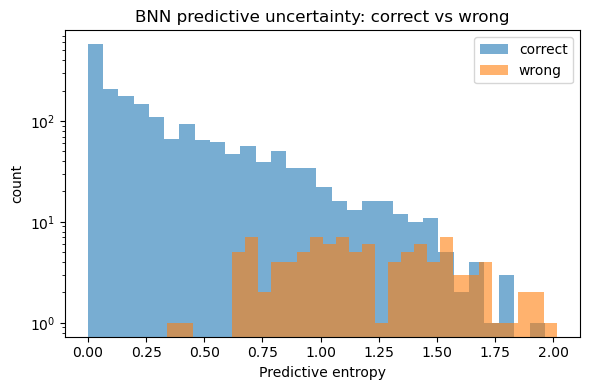

In [20]:
# =========================================================
# Cell 8 : uncertainty histogram
# =========================================================
plt.figure(figsize=(6,4))
plt.hist([e for e,c in zip(all_entropy, all_correct) if c], bins=30, alpha=0.6, label="correct")
plt.hist([e for e,c in zip(all_entropy, all_correct) if not c], bins=30, alpha=0.6, label="wrong")
plt.xlabel("Predictive entropy"); plt.ylabel("count")
plt.title("BNN predictive uncertainty: correct vs wrong")
plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()